# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [4]:
# откройте данные: ваш код здесь
# Импортируем pandas для работы с таблицами
import pandas as pd

# Указываем путь к нашему CSV-файлу с письмами
DATA_PATH = "data/spam_or_not_spam.csv"

# Считываем файл в DataFrame (таблицу)
df = pd.read_csv(DATA_PATH)

# Приводим имена колонок к нижнему регистру и убираем пробелы, чтобы проще было обращаться
df.columns = [c.strip().lower() for c in df.columns]

# Определяем, какие столбцы являются текстом и меткой (для автотестов либо вслепую)
TEXT_COL_CANDIDATES = ["email", "text", "message", "content"]      # возможные имена для текста
LABEL_COL_CANDIDATES = ["label", "is_spam", "target", "class", "category"]  # возможные имена для метки

def _pick_column(cols, candidates):
    """
    Возвращает первое совпадение из списка возможных названий колонок.
    Если ничего не найдено — выбрасывает ошибку.
    """
    for c in candidates:
        if c in cols:
            return c
    raise ValueError(f"Не найдено ни одной колонки из списка: {candidates}. Нашли: {list(cols)}")

# Определяем названия нужных столбцов
TEXT_COL = _pick_column(df.columns, TEXT_COL_CANDIDATES)
LABEL_COL = _pick_column(df.columns, LABEL_COL_CANDIDATES)

# Показываем первые строки таблицы и сводную информацию
display(df.head())                        # первые 5 строк
print("Колонки:", df.columns.tolist())    # список всех колонок
print("TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)
print("Всего строк:", len(df))            # общее количество сообщений

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


Колонки: ['email', 'label']
TEXT_COL: email | LABEL_COL: label
Всего строк: 3000


In [5]:
# рассчитайте частоты для классов: ваш код здесь
# Импортируем numpy — будем использовать для векторных операций
import numpy as np

# В нашем случае label уже содержит 0 (не спам) и 1 (спам)
# Создадим удобный булевый вектор, где True = спам
spam_mask = df["label"].astype(int) == 1

# Добавим новый столбец с бинарной меткой (на случай, если дальше будет использоваться)
# Здесь это просто дублирует label, но мы оставляем для единообразия
df["label_bin"] = spam_mask.astype(int)

# Подсчитаем, сколько писем каждого типа
count_ham = int((~spam_mask).sum())  # не спам
count_spam = int(spam_mask.sum())    # спам

# Соберём в словарь для удобного отображения
counts = {
    "ham": count_ham,
    "spam": count_spam,
}

# Выведем результат
print(f"Количество обычных писем (ham): {count_ham}")
print(f"Количество спам-писем (spam):   {count_spam}")
print(f"Всего сообщений: {len(df)}")

Количество обычных писем (ham): 2500
Количество спам-писем (spam):   500
Всего сообщений: 3000


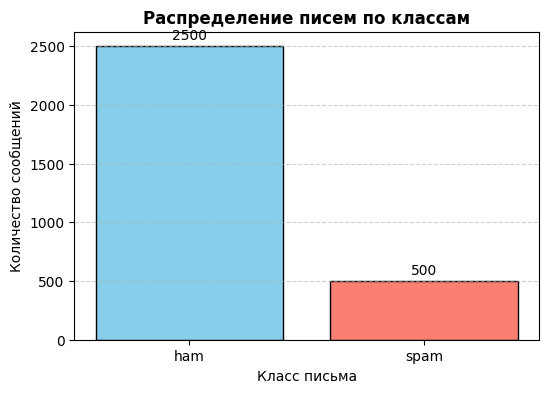

In [6]:
# визуализируйте результат: ваш код здесь
# Импортируем библиотеку для построения графиков
import matplotlib.pyplot as plt

# Подготавливаем данные для осей графика
names = ["ham", "spam"]                          # подписи категорий
values = [counts["ham"], counts["spam"]]         # числовые значения из словаря counts

# Создаём фигуру и оси. figsize=(6,4) — размеры окна графика.
plt.figure(figsize=(6, 4))

# Строим простую столбчатую диаграмму: две колонки — ham и spam
plt.bar(names, values, color=["skyblue", "salmon"], edgecolor="black")

# Добавляем заголовок и подписи осей для наглядности
plt.title("Распределение писем по классам", fontsize=12, fontweight="bold")
plt.xlabel("Класс письма", fontsize=10)
plt.ylabel("Количество сообщений", fontsize=10)

# Подписываем численные значения над каждой колонкой
for i, v in enumerate(values):
    plt.text(i, v + 30, str(v), ha="center", va="bottom", fontsize=10)

# Включаем сетку по оси Y (чтобы визуально было легче сравнивать)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Отображаем график
plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [7]:
# === ПРЕДОБРАБОТКА ДАННЫХ: ЗАМЕНА ПУСТЫХ СТРОК И УДАЛЕНИЕ ПРОПУСКОВ ===

# Импортируем pandas для работы с таблицей
import pandas as pd
import numpy as np

# Шаг 1. Заменяем все пустые строки или строки, состоящие только из пробелов, на NaN
# Метод .replace() ищет регулярным выражением строки, содержащие только пробелы (или пустые)
df["email"] = df["email"].replace(r"^\s*$", np.nan, regex=True)

# Шаг 2. Удаляем все строки, где в колонке email или label есть пропуски
df = df.dropna(subset=["email", "label"])

# Шаг 3. Проверим, сколько строк осталось после очистки
print(f"После очистки осталось {len(df)} строк из 3000")

После очистки осталось 2997 строк из 3000


Переводим данные в векторный вид:

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
# === ПЕРЕВОД ТЕКСТА В ВЕКТОРНОЕ ПРЕДСТАВЛЕНИЕ ===

# Импортируем класс CountVectorizer — он создаёт «мешок слов» (bag of words)
from sklearn.feature_extraction.text import CountVectorizer

# Создаём экземпляр векторизатора
# Можно ограничить размер словаря параметром max_features=5000, но пока оставим по умолчанию
vectorizer = CountVectorizer()

# Обучаем векторизатор на тексте и одновременно преобразуем текст в матрицу признаков
# fit_transform() делает две вещи: "fit" — строит словарь, "transform" — кодирует текст в векторы
X = vectorizer.fit_transform(df["email"])

# Посмотрим размерность полученной матрицы (число_строк, число_уникальных_слов)
print("Размерность матрицы признаков (кол-во писем × кол-во уникальных слов):", X.shape)


Размерность матрицы признаков (кол-во писем × кол-во уникальных слов): (2997, 34116)


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
# === ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===

# X у нас уже получен в Задании 2 (это разреженная матрица "писем × слова").
# Здесь просто явно укажем, что это матрица признаков:
X_features = X  # делаем явное имя, чтобы читалось: X_features = признаки

# Целевая переменная: бинарная метка 0/1 из столбца 'label'
# astype(int) — на случай, если тип не int; to_numpy() — получаем компактный вектор для sklearn
import numpy as np
y = df["label"].astype(int).to_numpy()

# Быстрая проверка на согласованность размеров
assert X_features.shape[0] == y.shape[0], "Число строк в X и y должно совпадать"
print("Форма X_features:", X_features.shape, "| Длина y:", y.shape[0])


Форма X_features: (2997, 34116) | Длина y: 2997


Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
# === СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ ДАННЫХ НА TRAIN/TEST ===

# train_test_split — штатный инструмент sklearn для разбиения выборки
# stratify=y — сохраняем долю классов в train и test такой же, как во всей выборке
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features,           # матрица признаков
    y,                    # вектор целевой переменной
    test_size=0.25,       # 25% в тестовую выборку
    random_state=42,      # фиксируем сид для воспроизводимости
    stratify=y            # стратификация по целевой переменной
)

# Покажем формы разбиений, чтобы убедиться, что всё корректно
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test: ", X_test.shape,  "| y_test: ", y_test.shape)

# Дополнительно проверим долю положительного класса (спама) до и после разбиения —
# при стратификации они должны быть примерно одинаковыми
overall_pos = y.mean()
train_pos = y_train.mean()
test_pos  = y_test.mean()
print(f"Доля спама: общая={overall_pos:.4f} | train={train_pos:.4f} | test={test_pos:.4f}")


X_train: (2247, 34116) | y_train: (2247,)
X_test:  (750, 34116) | y_test:  (750,)
Доля спама: общая=0.1658 | train=0.1660 | test=0.1653


Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
# === СРЕДНЕЕ ЗНАЧЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ НА TEST ===

# Для бинарной переменной 0/1 среднее равно доле единиц.
# Здесь это доля писем класса "spam" в тестовой выборке.
y_test_mean = float(y_test.mean())

print(f"Среднее значение целевой переменной (доля 'spam') на тесте: {y_test_mean:.4f}")

# Для наглядности выведем ещё и абсолютные количества
num_spam_test = int((y_test == 1).sum())
num_ham_test  = int((y_test == 0).sum())
print(f"В тесте: spam={num_spam_test}, ham={num_ham_test}, всего={y_test.shape[0]}")


Среднее значение целевой переменной (доля 'spam') на тесте: 0.1653
В тесте: spam=124, ham=626, всего=750


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [18]:
# # === ОБУЧЕНИЕ МОДЕЛИ: MULTINOMIAL NAIVE BAYES С alpha = 0.01 ===

# # Импортируем мультиномиальный наивный Байес — классический выбор для текстов,
# # где признаки представляют собой частоты слов из CountVectorizer.
# from sklearn.naive_bayes import MultinomialNB

# # alpha — параметр Лапласовского/Лидстоуновского сглаживания:
# # маленькое положительное число предотвращает нулевые вероятности для редких слов.
# clf = MultinomialNB(alpha=0.01)

# # Обучаем модель на обучающей части (матрица признаков X_train и целевые метки y_train).
# clf.fit(X_train, y_train)

# # Делаем предсказания классов на тестовой части — это 0/1 (ham/spam).
# y_pred = clf.predict(X_test)

# # Получаем вероятности принадлежности к положительному классу (spam=1),
# # они понадобятся для расчёта ROC-AUC и для построения ROC-кривой.
# y_proba = clf.predict_proba(X_test)[:, 1]

# # Короткая проверка размеров, чтобы убедиться, что всё согласовано.
# print("y_pred shape:", y_pred.shape, "| y_proba shape:", y_proba.shape)

# === Complement Naive Bayes — улучшенная версия для текстов и несбалансированных данных ===
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB(alpha=0.01)
clf.fit(X_train, y_train)

# Предсказания классов
y_pred = clf.predict(X_test)

# Вероятности для ROC-кривой
y_proba = clf.predict_proba(X_test)[:, 1]

print("y_pred shape:", y_pred.shape, "| y_proba shape:", y_proba.shape)


y_pred shape: (750,) | y_proba shape: (750,)


Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [19]:
# === ОЦЕНКА КАЧЕСТВА: НЕСКОЛЬКО МЕТРИК ===

# Импортируем метрики из sklearn.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Считаем основные метрики качества классификации.
acc  = accuracy_score(y_test, y_pred)                    # Доля верно классифицированных объектов
prec = precision_score(y_test, y_pred, zero_division=0)  # Точность: доля истинного спама среди предсказанного спама
rec  = recall_score(y_test, y_pred, zero_division=0)     # Полнота: доля найденного спама среди всего спама
f1   = f1_score(y_test, y_pred, zero_division=0)         # Гармоническое среднее точности и полноты
auc  = roc_auc_score(y_test, y_proba)                    # ROC-AUC по вероятностям положительного класса

# Матрица ошибок: [[TN, FP], [FN, TP]]
cm = confusion_matrix(y_test, y_pred)

# Печатаем метрики с округлением для компактности.
print({
    "accuracy": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1": round(f1, 4),
    "roc_auc": round(auc, 4),
})

# Дополнительно выведем матрицу ошибок — помогает понять баланс ошибок по классам.
print("Confusion matrix (TN, FP / FN, TP):")
print(cm)


{'accuracy': 0.988, 'precision': 1.0, 'recall': 0.9274, 'f1': 0.9623, 'roc_auc': 0.9951}
Confusion matrix (TN, FP / FN, TP):
[[626   0]
 [  9 115]]


Нарисуйте ROC-кривую:

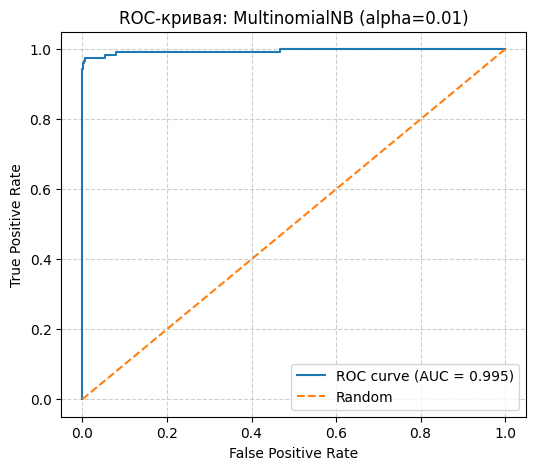

In [17]:
# === ROC-КРИВАЯ ДЛЯ ОЦЕНКИ КОМПРОМИССА МЕЖДУ TPR И FPR ===

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# roc_curve строится по истинным меткам и скору (вероятности положительного класса).
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Рисуем кривую: по оси X — False Positive Rate, по оси Y — True Positive Rate.
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.3f})")

# Добавим диагональ «случайного классификатора» для ориентира (качество 0.5).
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

# Подписи и легенда для читаемости.
plt.title("ROC-кривая: MultinomialNB (alpha=0.01)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)

# Показываем график.
plt.show()


## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

alpha=0.0010 | mean accuracy=0.9871
alpha=0.0028 | mean accuracy=0.9884
alpha=0.0077 | mean accuracy=0.9889
alpha=0.0215 | mean accuracy=0.9893
alpha=0.0599 | mean accuracy=0.9902
alpha=0.1668 | mean accuracy=0.9907
alpha=0.4642 | mean accuracy=0.9907
alpha=1.2915 | mean accuracy=0.9898
alpha=3.5938 | mean accuracy=0.9662
alpha=10.0000 | mean accuracy=0.8838

Лучшее значение alpha: 0.1668
Максимальная средняя accuracy: 0.9907


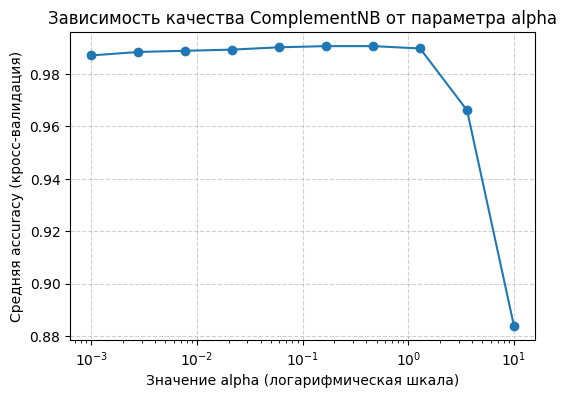

In [20]:
# === Перебор значений alpha с помощью кросс-валидации ===

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import ComplementNB
import numpy as np
import matplotlib.pyplot as plt

# Задаём список значений alpha, которые хотим проверить
# Чем больше alpha — тем сильнее сглаживание, тем менее чувствительна модель к редким словам.
alphas = np.logspace(-3, 1, 10)  # [0.001, 0.002, ..., 10] — логарифмически равномерная сетка

# Сюда будем сохранять средние значения accuracy по кросс-валидации
cv_scores = []

# Проходим по всем alpha
for a in alphas:
    model = ComplementNB(alpha=a)
    # Оцениваем качество с помощью 5-кратной кросс-валидации (разбивает train на 5 частей)
    # Используем X_train и y_train — кросс-валидация выполняется только на обучающей выборке.
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    print(f"alpha={a:.4f} | mean accuracy={mean_score:.4f}")

# Находим alpha с максимальным средним качеством
best_alpha = alphas[np.argmax(cv_scores)]
print("\nЛучшее значение alpha:", round(best_alpha, 4))
print("Максимальная средняя accuracy:", round(max(cv_scores), 4))

# === Визуализация зависимости качества от alpha ===
plt.figure(figsize=(6, 4))
plt.plot(alphas, cv_scores, marker="o")
plt.xscale("log")  # логарифмическая шкала по оси X
plt.xlabel("Значение alpha (логарифмическая шкала)")
plt.ylabel("Средняя accuracy (кросс-валидация)")
plt.title("Зависимость качества ComplementNB от параметра alpha")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
